In [2]:
#* project_deliverable_2.ipynb
#*
#* ANLY 555 2023
#* Project <>
#*
#* Due on: 10/04/2023
#* Author(s): Landon Carpenter
#*
#*
#* In accordance with the class policies and Georgetown's
#* Honor Code, I certify that, with the exception of the
#* class resources and those items noted below, I have neither
#* given nor received any assistance on this project other than
#* the TAs, professor, textbook and teammates.
#*

import csv
import nltk
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import os
import wordcloud as wordcloud

#create dataset class
class DataSet:
    """
    Class for managing the dataset
    
    Attribute:
        filename (str): the name of the file to be read in
    """

    #constructor
    def __init__(self, filename, ):
        """
        Initializes the DataSet class
        """
        self.filename = filename
        self.data = None

    #create the framework and stubs for __readFromCSV, __load, clean, and explore
    def __readFromCSV(self, filename, header = True):
        """
        Reads in the data from a CSV file. The data is stored on a column basis similar to a parquet file to more easily account for data types.
        """
        try:
            with open(filename, 'r') as f:
                reader = csv.reader(f)
                data = list(reader)

                if header:
                    header = data[0]
                    data = data[1:]
                else:
                    header = [f"col_{i}" for i in range(len(data[0]))]

                #init the dict to store the data
                columns = {col_name: [] for col_name in header}

                for row in data:
                    for col_name, value in zip(header, row):
                        try:
                            columns[col_name].append(float(value))
                        except:
                            columns[col_name].append(value)
                            #if the value is '' then replace it with np.nan
                            if value == '':
                                columns[col_name][-1] = np.nan
                            else:
                                pass


                #ok now convert to numpy array
                d_type = [(col_name, object if any(isinstance(val, str) for val in columns[col_name]) else float) for col_name in header]
                self.data = np.array(list(zip(*[columns[col_name] for col_name in header])), dtype = d_type)

        except Exception as e:
            print(f"Error reading {filename}: {str(e)}")

        return self.data

                    
                        



    #abstract base class (ABC)
    def __load(self, filename):
        """
        Loads the data from a CSV file
        """
        print(f"Loading {filename}...")

        #get the type of data
        data_type = self.getType()

        #if the data is time series set header to false
        if data_type == 'time':
            header = False
        else:
            header = True

        self.__readFromCSV(filename, header=header)

        return self.data


    def getType(self):
        """
        This function will be called later in each of the child classes to determine the type of data
        """

        #using while True to avoid infinite loop that I had earlier
        while True:
            data_type = input("Is this data Time Series, Text, Quantitative, or Qualitative? \nPlease type 'Time', 'Text', 'Quantitative', or 'Qualitative'.")
            #trying to make the prompt a little more forgiving by making the input lowercase and removing whitespace before checking for validity
            norm = data_type.lower().strip()

            #make sure the type is valid
            if norm in ['time', 'text', 'quantitative', 'qualitative']:
                return norm

            #if the type is not valid they will see this message and be prompted to try again
            else:
                print("Please enter a valid data type.")


    def clean(self):
        """
        Cleans the data
        """
        print("Cleaning...")

    def explore(self):
        """
        Explores the data
        """
        print("Exploring...")
        

#use inheritance to create TimeSeriesDataSet class
class TimeSeriesDataSet(DataSet):
    """
    Class for managing the time series dataset
    """

    #constructor
    def __init__(self, filename):
        """
        Initializes the TimeSeriesDataSet class
        """
        super().__init__(filename)
        self.filename = filename
        self.data = self._DataSet__load(filename)

    #override the clean and explore methods from the DataSet class to be specific to the TimeSeriesDataSet class
    def clean(self, filter_size = (3, 3)):
        """
        Cleans the time series data set
        """
        print("Cleaning Time Series Data Set...")

        #get the stored data that was read in 
        data = self.data

        names = self.data.dtype.names

        arr = []

        for row in data:
            row_arr = []
            for name in names:
                row_arr.append(row[name])

            arr.append(row_arr)
        arr = np.array(arr)

        pad = (filter_size[0] // 2, filter_size[1] // 2)
        print(f"padding: {pad}")
        rows, cols = arr.shape
        print(f"rows: {rows}, cols: {cols}")

        #to store the filtered data
        filtered_data = np.zeros((rows, cols))

        for i in range(rows):
            start, end = i - pad[0], i + pad[0] + 1

            #apply median filter over the row
            filtered_data[i] = np.median(arr[max(start, 0):min(end, rows)], axis = 0)

        self.data = filtered_data


    def explore(self):
        """
        Explores the time series data set by creating at least two visualizations.
        """
        print("Exploring Time Series Data Set...")

        #ask the user if they want to specify title, x-axis label, and y-axis label or use defaults
        custom = input("Would you like to specify the title, x-axis label, and y-axis label? \nPlease type 'Yes' or 'No'.")
        if custom == 'Yes':
            #get input to ask for the Title, X-axis label, and Y-axis label
            title = input("Please enter a title for the plot: ")
            x_label = input("Please enter a label for the x-axis: ")
            y_label = input("Please enter a label for the y-axis: ")
        else:
            #set the title, x-axis label, and y-axis label to default values
            title = "ECG Time Series Data"
            x_label = "Time"
            y_label = "Heartbeat"
        
        #set the figure size
        plt.figure(figsize=(10, 5))

        #ask for a row to explore
        row = int(input("Please enter a ID (row) to explore: "))

        #create a scatter plot, I genuinly need this one because I'm still unsure what is going on with this data. 
        #create a scatter plot of the row that was input which would likely be the patients ecg over the give time period (columns)
        plt.scatter(range(len(self.data[row])), self.data[row])

        #set the title, x-axis label, and y-axis label
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)

        #show the plot
        plt.show()

        plt.figure(figsize=(10, 5))

        #now create a line plot to show the distribution of the data with less noise
        plt.plot(range(len(self.data[row])), self.data[row])

        #set the title, x-axis label, and y-axis label
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)

        #show the plot
        plt.show()


nltk.download('stopwords')

class TextDataSet(DataSet):
    """
    Class for managing the text dataset. 
    """

    def __init__(self, filename):
        """
        Initializes the TextDataSet class
        """
        super().__init__(filename)
        self.filename = filename
        self.data = self._DataSet__load(filename)

    def clean(self):
        """
        Cleans the text data set
        """
        print("Cleaning Text Data Set...")

        stop_words = set(stopwords.words('english'))

        #if the column is a string then remove stop words
        for col in self.data.dtype.names:
            if col == 'text':
                col_data = self.data[col]

                for i in range(len(col_data)):
                    word_tokens = nltk.word_tokenize(col_data[i])

                    filtered_sentence = [w for w in word_tokens if not w in stop_words]

                    filtered_sentence = []

                    for w in word_tokens:
                        if w not in stop_words:
                            filtered_sentence.append(w)

                    col_data[i] = filtered_sentence

                self.data[col] = col_data

        #lemmatize the data
        for col in self.data.dtype.names:
            if col == 'text':
                col_data = self.data[col]

                for i in range(len(col_data)):
                    lemmatizer = nltk.stem.WordNetLemmatizer()
                    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in col_data[i]])
                    col_data[i] = lemmatized_output

                self.data[col] = col_data

    def explore(self):
        """
        Explores the text data set
        """
        print("Exploring Text Data Set...")

        #ask the user if they want to specify title, x-axis label, and y-axis label or use defaults
        custom = input("Would you like to specify the title, x-axis label, and y-axis label for the word cloud? \nPlease type 'Yes' or 'No'.")
        if custom == 'Yes':
            #get input to ask for the Title, X-axis label, and Y-axis label
            title = input("Please enter a title for the plot: ")
            x_label = input("Please enter a label for the x-axis: ")
            y_label = input("Please enter a label for the y-axis: ")

        else:
            #set the title, x-axis label, and y-axis label to default values
            title = "Word Cloud"
            x_label = ""
            y_label = ""

        #create a word cloud from the top 100 words
        cloud = wordcloud.WordCloud().generate(self.data['text'][0])
        plt.imshow(cloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

        #send self.data['stars'] to ints for histogram
        self.data['stars'] = self.data['stars'].astype(int)

        custom = input("Would you like to specify the title, x-axis label, and y-axis label for the histogram? \nPlease type 'Yes' or 'No'.")

        if custom == 'Yes':
            #get input to ask for the Title, X-axis label, and Y-axis label
            title = input("Please enter a title for the plot: ")
            x_label = input("Please enter a label for the x-axis: ")
            y_label = input("Please enter a label for the y-axis: ")
        
        else:
            #set the title, x-axis label, and y-axis label to default values
            title = "Histogram of Ratings"
            x_label = "Rating"
            y_label = "Frequency"

        #histogram for 1 through 5 star ratings
        plt.hist(self.data['stars'], bins = 5)
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.show()



#use inheritance to create QuantDataSet class
class QuantDataSet(DataSet):
    """
    Class for managing the quantitative dataset
    """

    #constructor
    def __init__(self, filename):
        """
        Initializes the QuantDataSet class
        """
        super().__init__(filename)
        self.filename = filename
        self.data = self._DataSet__load(filename)

    #override the clean and explore methods from the DataSet class to be specific to the QuantDataSet class
    def clean(self, header = True):
        """
        Cleans the quantitative data set
        """
        try: 
            if self.data is None:
                self._DataSet__load(self.filename)

            print("Cleaning Quant Data Set...")

            #iterate by column replacing missing values with the mean
            for col_name in self.data.dtype.names:
                col_data = self.data[col_name]

                #if the data is numeric
                if np.issubdtype(col_data.dtype, np.number):
                    #replace missing values with the mean limited to 2 decimal places
                    col_data[np.isnan(col_data)] = np.round(np.nanmean(col_data), 2)
                    
        except Exception as e:
            print(f"Error cleaning {self.filename}: {str(e)}")

    def explore(self):
        """
        Explores the quantitative data set
        """
        print("Exploring Quant Data Set...")

        #ask the user for a Product ID to visualize
        product_id = input("Please enter a Product ID to visualize: ")

        i = 0
        for row in self.data:
            if row['Product_Code'] == product_id:
                row_indx = i 
            i += 1


        data_names = []
        for i in range(0, 52):
            data_names.append(f'Normalized {i}')

        vals = []

        for name in data_names:
            vals.append(self.data[row_indx][name])

        #create a bar plot using vals with the data_names as the x-axis labels and the title, x-axis label, and y-axis label as specified by the user if they want
        custom = input("Would you like to specify the title, x-axis label, and y-axis label for the bar plot? \nPlease type 'Yes' or 'No'.")
        if custom == 'Yes':
            #get input to ask for the Title, X-axis label, and Y-axis label
            title = input("Please enter a title for the plot: ")
            x_label = input("Please enter a label for the x-axis: ")
            y_label = input("Please enter a label for the y-axis: ")

        else:
            #set the title, x-axis label, and y-axis label to default values
            title = (f"Normalized Sales | Product ID: {product_id}")
            x_label = "Week"
            y_label = "Normalized Sales"

        plt.bar(data_names, vals)
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        #get rid of x-axis labels because they are too long
        plt.xticks([])

        plt.show()

        #do the same for non-normalized sales
        data_names = []
        for i in range(0, 52):
            data_names.append(f'W{i}')

        #sum each product to get the total sales for each week
        total_sales = []

        for i in range(0, 52):
            total_sales.append(np.sum(self.data[f'W{i}']))

        #create a bar plot using vals with the data_names as the x-axis labels and the title, x-axis label, and y-axis label as specified by the user if they want
        custom = input("Would you like to specify the title, x-axis label, and y-axis label for the bar plot? \nPlease type 'Yes' or 'No'.")
        if custom == 'Yes':
            #get input to ask for the Title, X-axis label, and Y-axis label
            title = input("Please enter a title for the plot: ")
            x_label = input("Please enter a label for the x-axis: ")
            y_label = input("Please enter a label for the y-axis: ")
        else:
            #set the title, x-axis label, and y-axis label to default values
            title = "Total Sales | Every Product"
            x_label = "Week"
            y_label = "Total Sales"

        plt.bar(data_names, total_sales)
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        #get rid of x-axis labels because they are too long
        plt.xticks([])
        plt.show()
        


#use inheritance to create QualDataSet class
class QualDataSet(DataSet):
    """
    Class for managing the qualitative dataset
    """

    #constructor
    def __init__(self, filename):
        """
        Initializes the QualDataSet class
        """
        super().__init__(filename)
        self.filename = filename
        self.data = self._DataSet__load(filename)

    #override the clean and explore methods from the DataSet class to be specific to the QualDataSet class
    def clean(self):
        """ 
        Cleans the qualitative data set, replacing missing values in numeric columns with the median and replacing missing values in string columns with the mode.
        """
        print("Cleaning Qual Data Set...")

        try:
            for col_name in self.data.dtype.names:
                col_data = self.data[col_name]

                #if the data is numeric
                if np.issubdtype(col_data.dtype, np.number):
                    #replace missing values with the median limited to 2 decimal places
                    col_data[np.isnan(col_data)] = np.round(np.nanmedian(col_data), 2)
                else:
                    #convert any np.nan to 'nan' so mode can be used
                    col_data[col_data != col_data] = 'nan'
                    #replace missing values with the mode
                    mode = max(set(col_data), key = list(col_data).count)
                    col_data[col_data == 'nan'] = mode
                
                self.data[col_name] = col_data
        
        except Exception as e:
            print(f"Error cleaning {self.filename}: {str(e)}")
        

                    
    def explore(self):
        """
        Explores the qualitative data set
        """
        print("Exploring Qual Data Set...")

        #


#create class for the classifier 
class ClassifierAlgotithm:
    """
    Class for managing the classifier algorithm
    """
    def __init__(self):
        """
        Initializes the ClassifierAlgotithm class
        """
        pass

    def train(self):
        """
        Trains the classifier algorithm
        """
        print("Training...")

    def test(self):
        """
        Tests the classifier algorithm
        """
        print("Testing...")

#create class for simpe KNN that inherets from ClassifierAlgotithm
class simpleKNNClassifier(ClassifierAlgotithm):
    """
    Class for managing the simple KNN classifier
    """
    def __init__(self):
        """
        Initializes the simpleKNNClassifier class
        """
        super().__init__()

#create class for kdTree KNN that inherets from ClassifierAlgotithm
class kdTreeKNNClassifier(ClassifierAlgotithm):
    """
    Class for managing the kdTree KNN classifier
    """
    def __init__(self):
        super().__init__()

#create the Experiment class that will run cross validation, get a score given k and, and create a confusion matrix
class Experiment:
    """
    Class for managing the experiment
    """

    def __init__(self):
        """
        Initializes the Experiment class
        """
        pass

    def runCrossVal(self, k):
        """
        Runs k-fold cross validation

        Args:
            k (int): the number of folds to use
        """
        print(f"Running {k}-fold cross validation...")

    def score(self):
        """
        Scores the experiment
        """
        print("Scoring...")

    def __confusionMatrix(self):
        """
        Creates a confusion matrix
        """
        print("Creating confusion matrix...")

# #main function: if the py file is ran directly then run the main function and perform the following (rather than importing the file and using a function, for example)
# if __name__ == "__main__":
#     print("Running main to show framework and stubs...")
#     print("\n")
#     print("---Creating dataset---")
#     dataset = DataSet("my_data.csv")
#     dataset._DataSet__readFromCSV("my_data.csv")
#     dataset._DataSet__load("my_data.csv")
#     dataset.clean()
#     dataset.explore()
#     print("\n")
    
#     print("---Creating TimeSeriesDataSet--- ")
#     ts_dataset = TimeSeriesDataSet("my_data.csv")
#     ts_dataset._DataSet__readFromCSV("my_data.csv")
#     ts_dataset._DataSet__load("my_data.csv")
#     ts_dataset.clean()
#     ts_dataset.explore()
#     print("\n")

#     print("---Creating QuantDataSet---")
#     quant_dataset = QuantDataSet("my_data.csv")
#     quant_dataset._DataSet__readFromCSV("my_data.csv")
#     quant_dataset._DataSet__load("my_data.csv")
#     quant_dataset.clean()
#     quant_dataset.explore()
#     print("\n")

#     print("---Creating QualDataSet---")
#     qual_dataset = QualDataSet("my_data.csv")
#     qual_dataset._DataSet__readFromCSV("my_data.csv")
#     qual_dataset._DataSet__load("my_data.csv")
#     qual_dataset.clean()
#     qual_dataset.explore()
#     print("\n")

#     print("---Creating simple KNN classifiers---")
#     simple_knn = simpleKNNClassifier()
#     simple_knn.train()
#     simple_knn.test()
#     print("\n")

#     print("---Creating kdTree KNN classifiers--- ")
#     kd_tree_knn = kdTreeKNNClassifier()
#     kd_tree_knn.train()
#     kd_tree_knn.test()
#     print("\n")

#     print("---Creating experiment--- ")
#     experiment = Experiment()
#     experiment.runCrossVal(5)
#     experiment.score()
#     experiment._Experiment__confusionMatrix()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lando\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#read in "test.csv" as my_test using DataSet and __readFromCSV
test_object = DataSet("Quant_Test.csv")
vars(test_object)

{'filename': 'Quant_Test.csv', 'data': None}

In [4]:
#load the data using __load as quant_test
quant_test = QuantDataSet("Quant_Test.csv")
print(f"---Vars---")
print(vars(quant_test))
#clean the data using clean
quant_test.clean()
print("---Vars---")
print(vars(quant_test))

Loading Quant_Test.csv...
---Vars---
{'filename': 'Quant_Test.csv', 'data': array([('P1', 11., 12., 10., 8., 13., 12., 14., 21.,  6., 14., 11., 14., 16., 9.,  9., 9., 14.,  9.,  3., 12., 5., 11.,  7., 12.,  5., 9.,  7., 10., 5., 11.,  7., 10., 12.,  6., 5., 14., 10.,  9., 12., 17.,  7., 11., 4.,  7., 8., 10., 12., 3.,  7., 6., 5., 10., 3., 21., 0.44, 0.5 , 0.39, 0.28, 0.56, 0.5 , 0.61, 1.  , 0.17, 0.61, 0.44, 0.61, 0.72, 0.33, 0.33, 0.33, 0.61, 0.33, 0.  , 0.5 , 0.11, 0.44, 0.22, 0.5 , 0.11, 0.33, 0.22, 0.39, 0.11, 0.44, 0.22, 0.39, 0.5 , 0.17, 0.11, 0.61, 0.39, 0.33, 0.5 , 0.78, 0.22, 0.44, 0.06, 0.22, 0.28, 0.39, 0.5 , 0.  , 0.22, 0.17, 0.11, 0.39),
       ('P2',  7.,  6.,  3., 2.,  7.,  1.,  6.,  3.,  3.,  3.,  2.,  2.,  6., 2.,  0., 6.,  2.,  7.,  7.,  9., 4.,  7.,  2.,  4.,  5., 3.,  5.,  8., 5.,  5.,  3.,  1.,  3.,  2., 3., 10.,  5.,  2.,  7.,  3.,  2.,  5., 2.,  4., 5.,  1.,  1., 4.,  5., 1., 6.,  0., 0., 10., 0.7 , 0.6 , 0.3 , 0.2 , 0.7 , 0.1 , 0.6 , 0.3 , 0.3 , 0.3 , 0.2 , 0.2

In [5]:
qual_test = QualDataSet("data\Qual_Survey.csv")
print(f"---Vars---")
print(vars(qual_test))
#clean the data using clean
qual_test.clean()
print("---Vars---")
print(vars(qual_test))

Loading data\Qual_Survey.csv...
Error reading data\Qual_Survey.csv: [Errno 2] No such file or directory: 'data\\Qual_Survey.csv'
---Vars---
{'filename': 'data\\Qual_Survey.csv', 'data': None}
Cleaning Qual Data Set...
Error cleaning data\Qual_Survey.csv: 'NoneType' object has no attribute 'dtype'
---Vars---
{'filename': 'data\\Qual_Survey.csv', 'data': None}


In [6]:
time_test = TimeSeriesDataSet("Time_Test.csv")
print(f"---Vars---")
print(vars(time_test))
#clean the data using clean
time_test.clean()
print("---Vars---")
print(vars(time_test))
print(f"---Data---")

Loading Time_Test.csv...
---Vars---
{'filename': 'Time_Test.csv', 'data': array([(0.978, 0.926, 0.681, 0.245 , 0.154 , 0.191 , 0.152 , 0.0858, 0.0588 , 0.049 , 0.0441, 0.0613, 0.0662 , 0.0613, 0.049 , 0.0735, 0.0613, 0.0613, 0.0662, 0.0686, 0.0956, 0.076 , 0.0931, 0.105 , 0.115 , 0.103  , 0.118  , 0.125, 0.142 , 0.127 , 0.152 , 0.145 , 0.164 , 0.145 , 0.159 , 0.152 , 0.154, 0.142 , 0.152 , 0.152  , 0.147 , 0.132  , 0.127 , 0.135 , 0.137 , 0.113 , 0.108 , 0.105 , 0.108 , 0.098 , 0.0931, 0.103 , 0.1   , 0.105 , 0.103 , 0.118 , 0.105 , 0.123 , 0.127 , 0.142 , 0.147  , 0.145 , 0.174 , 0.23  , 0.238 , 0.248 , 0.23  , 0.225  , 0.199  , 0.176  , 0.132 , 0.125  , 0.118 , 0.123 , 0.113 , 0.13   , 0.115 , 0.0833, 0.    , 0.0662, 0.306 , 0.613 , 0.86  , 1.    , 0.958 , 0.745 , 0.304 , 0.164 , 0.206 , 0.164  , 0.103 , 0.0956, 0.0907, 0.1   , 0.0956, 0.098 , 0.0931, 0.098 , 0.0956, 0.113 , 0.     , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.     , 0.    , 0.    , 0.    , 0.    , 0.   , 0.   

In [7]:
print(len(time_test.data))
print(time_test.data)

10
[[0.969  0.8945 0.5715 ... 0.     0.     0.    ]
 [0.978  0.863  0.462  ... 0.     0.     0.    ]
 [0.96   0.666  0.462  ... 0.     0.     0.    ]
 ...
 [0.717  0.792  0.48   ... 0.     0.     0.    ]
 [0.874  0.849  0.48   ... 0.     0.     0.    ]
 [0.937  0.9225 0.5875 ... 0.     0.     0.    ]]


In [8]:
text_test = TextDataSet("Text_Test.csv")
print(f"---Vars---")
print(vars(text_test))
#clean the data using clean
text_test.clean()
print("---Vars---")
print(vars(text_test))


Loading Text_Test.csv...
---Vars---
{'filename': 'Text_Test.csv', 'data': array([('9yKzy9PApeiPPOUJEtnvkg', '1/26/2011', 'fWKvX83p0-ka4JS3dc6E5A', 1., 'My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.\n\nDo yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I\'ve ever had.  I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.\n\nWhile EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I

Exploring Time Series Data Set...


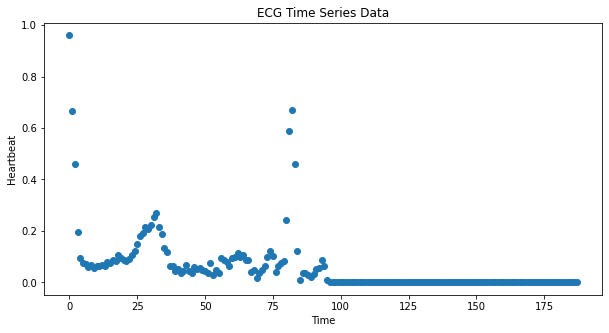

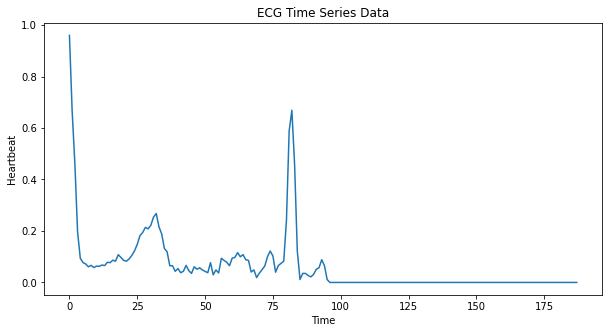

In [9]:
time_test
#explore the time test
time_test.explore()

Exploring Text Data Set...


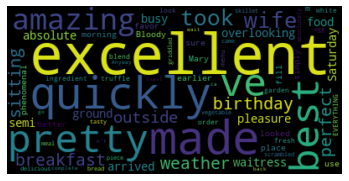

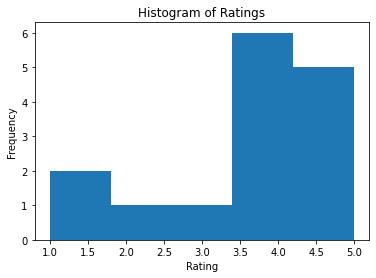

In [10]:
text_test
#explore the text test
text_test.explore()

In [11]:
print(f"---Data - Quant Test Names---")
print(quant_test.data.dtype.names)
print(f"---Data - Quant Test---")


---Data - Quant Test Names---
('Product_Code', 'W0', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9', 'W10', 'W11', 'W12', 'W13', 'W14', 'W15', 'W16', 'W17', 'W18', 'W19', 'W20', 'W21', 'W22', 'W23', 'W24', 'W25', 'W26', 'W27', 'W28', 'W29', 'W30', 'W31', 'W32', 'W33', 'W34', 'W35', 'W36', 'W37', 'W38', 'W39', 'W40', 'W41', 'W42', 'W43', 'W44', 'W45', 'W46', 'W47', 'W48', 'W49', 'W50', 'W51', 'MIN', 'MAX', 'Normalized 0', 'Normalized 1', 'Normalized 2', 'Normalized 3', 'Normalized 4', 'Normalized 5', 'Normalized 6', 'Normalized 7', 'Normalized 8', 'Normalized 9', 'Normalized 10', 'Normalized 11', 'Normalized 12', 'Normalized 13', 'Normalized 14', 'Normalized 15', 'Normalized 16', 'Normalized 17', 'Normalized 18', 'Normalized 19', 'Normalized 20', 'Normalized 21', 'Normalized 22', 'Normalized 23', 'Normalized 24', 'Normalized 25', 'Normalized 26', 'Normalized 27', 'Normalized 28', 'Normalized 29', 'Normalized 30', 'Normalized 31', 'Normalized 32', 'Normalized 33', 'Normalized 34', 

Exploring Quant Data Set...


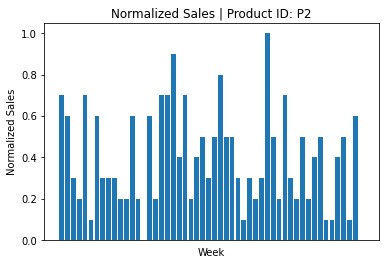

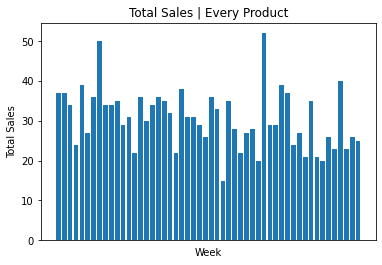

In [12]:
quant_test.explore()